# Practical 3: Transfer Learning

This is the second task of Practical 3. You will use transfer learning to build a convolutional neural network to tackle the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). 
You could select an existing trained model (VGG16 excluded) from Keras (https://keras.io/api/applications/) and fine-tune it to solve the classification problem of CIFAR-10. 

We will mark your code based on the accuracy of your model. You should try to get **at least 80%** accuracy on this dataset. Don't forget to save and check in your model. 

## Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical

In [2]:
tf.__version__

'2.4.0'

In [3]:
tf.keras.__version__

'2.4.0'

## Prepare the dataset

In this block, you will prepare the data for the training, such as apply the preprocess function of your selected model and perform data augmentation. 

170500096/170498071 [==============================] - 2s 0us/step


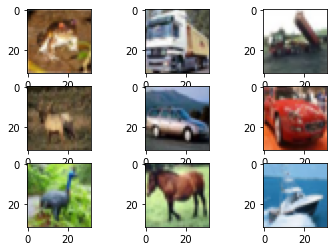

(50000, 32, 32, 3)

In [4]:
from keras.datasets import cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train_full[i])
plt.show()

X_train_full.shape

In [5]:
# We use one-hot encoding here for the labels
y_train = to_categorical(y_train_full)
y_test = to_categorical(y_test)

X_train =X_train_full.astype('float32')
X_test = X_test.astype('float32')
X_train=X_train/255
X_test=X_test/255

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, train_size=0.7)

In [7]:
X_train.shape

(35000, 32, 32, 3)

In [8]:
X_valid.shape

(15000, 32, 32, 3)

In [9]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Lambda
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input


from keras.optimizers import Adam, SGD, RMSprop
from keras.utils import to_categorical

## Build and train the model

Build and train your model. 

In [10]:
# TODO: load the model you selected
input_tensor=Input((224,224,3))
# Here, we load the model without its fully connected layer
base_model = Xception(weights="imagenet", include_top=False, input_tensor=input_tensor)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
# #Here we freeze the base model
base_model.trainable=False
data_resize=Sequential([
               Lambda(lambda image: tf.image.resize(image, (224,224)))         #We add Lambda layer that takes in the 32x32 input and resizes it into 224x224 according to how the Xception was originally trained
])
inputs=Input((32,32,3))
x=data_resize(inputs)
x=base_model(x, training=False)
x=Flatten()(x)   #We added a flatten layer which prepares a vector for the fully connected layers
x=BatchNormalization()(x)
x=Dense(256, activation='relu')(x)
x=Dropout(0.5)(x)
x=BatchNormalization()(x)
x=Dense(128, activation='relu')(x)
x=Dropout(0.5)(x)
x=BatchNormalization()(x)
x=Dense(64, activation='relu')(x)
x=Dropout(0.5)(x)
x=BatchNormalization()(x)
outputs=Dense(10, activation='softmax')(x)
# this is the model we will train
model=keras.Model(inputs,outputs)


check_no_fine=ModelCheckpoint(filepath="cifar10_Xception_NoFine.h5", monitor="val_accuracy", mode="max", save_best_only=True)
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, 32,32,3))

#Although we tried with these optimizer learning rate combinations, by looking at the first few epochs, we concluded that Adam optimizer with 0.001 learning rate has better convergence properties.
# model.compile(optimizer=Adam(1e-2), loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=RMSprop(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])


83689472/83683744 [==============================] - 0s 0us/step


In [11]:
# show the structure of your model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0     

In [12]:
batch_size = 32     #We tried batch size of 64 and 128 too but batch size of 32 worked best for our model
num_epoch = 15
#We keep the training history
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epoch, verbose=1, validation_data=(X_valid, y_valid), callbacks=[check_no_fine])

Epoch 1/15
1094/1094 [==============================] - 254s 223ms/step - loss: 1.5472 - accuracy: 0.4936 - val_loss: 0.5050 - val_accuracy: 0.8328
Epoch 2/15
1094/1094 [==============================] - 251s 230ms/step - loss: 0.7557 - accuracy: 0.7682 - val_loss: 0.4593 - val_accuracy: 0.8463
Epoch 3/15
1094/1094 [==============================] - 251s 230ms/step - loss: 0.6524 - accuracy: 0.8001 - val_loss: 0.4357 - val_accuracy: 0.8550
Epoch 4/15
1094/1094 [==============================] - 251s 230ms/step - loss: 0.5897 - accuracy: 0.8211 - val_loss: 0.4256 - val_accuracy: 0.8571
Epoch 5/15
1094/1094 [==============================] - 252s 230ms/step - loss: 0.5333 - accuracy: 0.8376 - val_loss: 0.4294 - val_accuracy: 0.8583
Epoch 6/15
1094/1094 [==============================] - 251s 230ms/step - loss: 0.4804 - accuracy: 0.8529 - val_loss: 0.4303 - val_accuracy: 0.8580
Epoch 7/15
1094/1094 [==============================] - 251s 230ms/step - loss: 0.4504 - accuracy: 0.8629 - val_

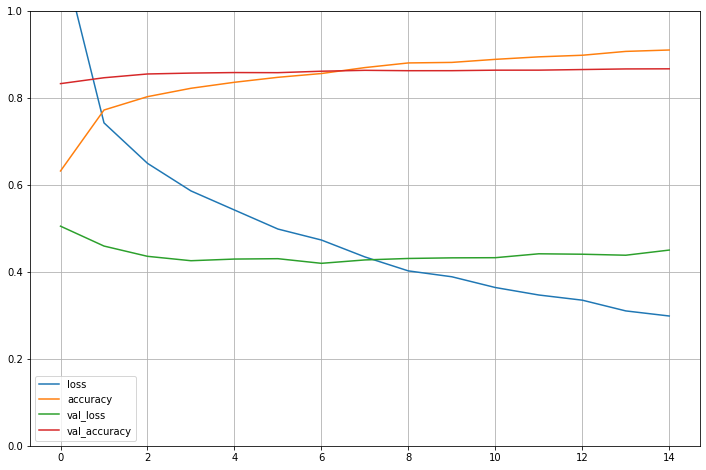

In [13]:
# Assume you have stored the training history in the variable "history"
# Show the learning curves
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.gca().set_ylim(0, 1)
plt.grid(True)
plt.show()

In [1]:
#Here the reason that validation accuracy is sometime better than training accuracy is we used dropout layers, so prediction for training is done with less neurons than for the validation which uses all the neurons.

In [14]:
#Save the non-fine tuned model
model.save('cifar10_Xception_NoFine.h5')

# Fine Tuning

In [18]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable=True

# It's important to recompile our model after we make any changes
# to the `trainable` attribute of any inner layer, so that the changes
# are taken into account
#We chose a very low learning rate since we do not want the model to overfit
model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
check_fine=ModelCheckpoint(filepath="cifar10_Xception_Fine.h5", monitor="val_accuracy", mode="max", save_best_only=True)


batch_size = 32
num_epoch = 15
# #We keep the training history
history_fine = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epoch, verbose=1, validation_data=(X_valid, y_valid), callbacks=[check_fine])

Epoch 1/15
1094/1094 [==============================] - 808s 734ms/step - loss: 0.2847 - accuracy: 0.9182 - val_loss: 0.3143 - val_accuracy: 0.9057
Epoch 2/15
1094/1094 [==============================] - 806s 737ms/step - loss: 0.2869 - accuracy: 0.9191 - val_loss: 0.2853 - val_accuracy: 0.9152
Epoch 3/15
1094/1094 [==============================] - 806s 737ms/step - loss: 0.2112 - accuracy: 0.9404 - val_loss: 0.3666 - val_accuracy: 0.8914
Epoch 4/15
1094/1094 [==============================] - 797s 729ms/step - loss: 0.1941 - accuracy: 0.9443 - val_loss: 0.2532 - val_accuracy: 0.9261
Epoch 5/15
1094/1094 [==============================] - 792s 724ms/step - loss: 0.1616 - accuracy: 0.9559 - val_loss: 0.2424 - val_accuracy: 0.9269
Epoch 6/15
1094/1094 [==============================] - 791s 723ms/step - loss: 0.1353 - accuracy: 0.9644 - val_loss: 0.2454 - val_accuracy: 0.9297
Epoch 7/15
1094/1094 [==============================] - 791s 723ms/step - loss: 0.1336 - accuracy: 0.9646 - val_

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0     

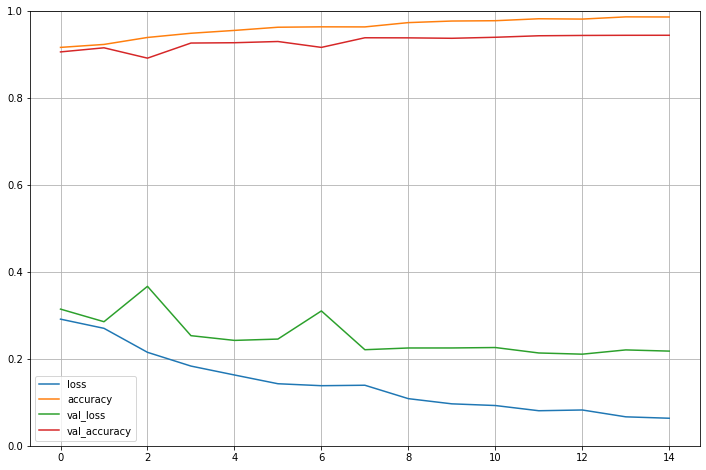

In [20]:
# Assume you have stored the training history in the variable "history"
# Show the learning curves
pd.DataFrame(history_fine.history).plot(figsize=(12, 8))
plt.gca().set_ylim(0, 1)
plt.grid(True)
plt.show()

## Save the model

In [21]:
#Save the fine tuned model
model.save('cifar10_Xception_FineEndOfTrain.h5')
from google.colab import files
files.download("cifar10_Xception_FineEndOfTrain.h5") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Load the model and evaluate it on the test data

In [23]:
model = keras.models.load_model("cifar10_Xception_FineEndOfTrain.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 50s 157ms/step - loss: 0.2307 - accuracy: 0.9413


[0.23070043325424194, 0.9412999749183655]

In [24]:
model2 = keras.models.load_model("cifar10_Xception_Fine.h5")
model2.evaluate(X_test, y_test)

313/313 [==============================] - 50s 158ms/step - loss: 0.2307 - accuracy: 0.9413


[0.23070043325424194, 0.9412999749183655]

## Short report

Please write briefly how you build and train the model. Please include the decisions you made, such as how you decide the number of layers reused from the selected model, and the difficulties you met.

The Practical 3 was completed by the following student(s): Barış Özakar

# Base model decision
Here we will tell about our process of building and training our model and our decisions while doing so. Firstly, we needed to decide on a pretrained model. Before we made our final choice of Xception model, we also tried ResNet50 and InceptionV3. For all of these pretrained models trained on the "ImageNet" dataset, we took all the layers except the top layers to do the transfer learning. We froze the base model layers and added dense layers to be trained on the CIFAR 10 dataset. We have realized that ResNet50 had a long training time, possibly caused by the sheer size of the base model. Therefore, it took very long to train ResNet50. Judging by the first few epoch accuracies, we decided that Xception model is the model that we wish to use as our base model.

# Model design
Our model consists of a Lambda layer, the Xception base model and fully connected layers (which have batch normalization and dropout layers inbetween). The Lambda layer resizes the input (32, 32) into (224, 224) which makes sure Xception model behaves optimally as it was originally trained on a (224, 224) input. The Dense layers have a converging scheme going from (256, 128, 64, 10). Without dropout and batch normalization layers, we have realized that the models that we trained were overfitting. Therefore, we added these layers. However, these layers significantly increased our training time.

# Training
In the CIFAR-10 dataset, we have a total of 60000 images consisting of 10 categories. In order to train and validate our model, we have separated the initial dataset into 35000, 15000 and 10000 images for training, validation and testing datasets respectively. For our training, we have appropriately used categorical cross-entropy as our loss function. 
In terms of optimizers, we have experimented with SGD, RMSProp and Adam optimizers, however we finally empirically decided on Adam as it converged faster with a learning rate of 0.001 for the initial training with frozen base model layers. We have tried other learning rate values however, learning rate of 0.001 had the best convergence properties. We used a batch size of 32 with 15 epochs and our training and validation set accuracies were 91.18% and 86.69% respectively.  

# Fine-Tuning
After the first training, we have fine-tuned the model by unfreezing the base model. However, we made sure that it kept running in inference mode, which was ensured by passing `training=False` when calling it. This meant that the batchnorm layers would not update their batch statistics. This prevented the batchnorm layers from undoing all the training we've done so far. For the fine-tuning training, we made sure to use a very low learning rate since we do not want the model to overfit. Therefore, we used a learning rate of 0.00001. For fine-tuning, we again used a batch size of 32 with 15 epochs and our training and validation set accuracies improved up to  98.53% and 94.40% respectively. Upon testing our fine-tuned model on the test set, we have achieved an accuracy of 94.13%, which is above the benchmark expectations of 80%. 

# Difficulties
Long training times and getting the accuracy over 80% was among the main difficulties that we faced. In order to solve long training times, we have decided to use Google Colab so that training was faster. Getting the accuracy over 80% took empirical observations and changes to our model and our hyperparameters (addition of dropout and batchnormalization layers, determining a learning rate that is suitable, adding the right amount of dense layers/neurons to allow for successful decision making).

# References
https://keras.io/guides/transfer_learning/

https://keras.io/api/applications/